In [1]:
import tensorflow as tf

import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
dir_path = os.getcwd()

In [3]:
#load embendings

embeddings = np.loadtxt(os.path.join(dir_path,'cache','embeddings.vec'))

pickle_in = open('cache/database.dict', 'rb')
db = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open('cache/traindata.list', 'rb')
traindata = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open('cache/data2onehot.dict', 'rb')
dictionary = pickle.load(pickle_in)
pickle_in.close()

In [4]:
longest = np.argmax(list(map(lambda x : len(x),traindata)))

In [5]:
print(longest)

1662


In [6]:
print(len(traindata[longest]))

47701


In [7]:
from JavaClassParser import ByteCode
reverse_dictionary = dict(zip(dictionary.values(),dictionary.keys()))
X_train=[]
Ylabels=[]
X_train_long=[]
Ylabels_long=[]
X_labels = []
Y_labels = []

X_if = []
Y_if = []

for dclass in db.values():
    for method in dclass.values():
        instructions = method['x']
        labels = method['y']
        byteIndex = method['index']
        
        #
        #seperating by labels
        
        cur_section = []
        cur_label = labels[0]
        for instruction, label in zip(instructions,labels):
            if label != cur_label:
                if len(cur_section)<100:
                    X_train.append(cur_section)
                    Ylabels.append(cur_label)
                else:
                    X_train_long.append(cur_section)
                    Ylabels_long.append(cur_label)
                X_labels.append(cur_section)
                Y_labels.append(cur_label)
                cur_section = []
                cur_label = label
            cur_section.append(dictionary.get(instruction,0))
        
        #print(instructions)
        
        
        #
        #seperating by if jumps
        
        for i,label in zip(range(len(instructions)),labels):
        #index = method[i]
        #instruction = reverse_dictionary[index]
            instruction = instructions[i]
            if 'if' in instruction[:2]:
                #offset = int(reverse_dictionary[method[i+1]])
                offset = int(instructions[i+1])
                j = i
                step = np.sign(offset)
                curr = byteIndex[i]
                end = curr+offset
                section = []
                while(curr!=end):
                    section.append(dictionary.get(instructions[j],0))
                    if instructions[j] in ByteCode.mnemonicMap:
                        #curr += ByteCode.mnemonicMap[instructions[j]].getOpCodeCount() + 1
                        curr = byteIndex[j]
                    j += step
                    if curr>=abs(offset):
                        argCounts = ByteCode.mnemonicMap[instructions[j-step]].argsCount
                        for arg in argCounts:
                            if arg > 0:
                                section.append(dictionary.get(instructions[j],0))
                                j += step
                        break

                if offset<0:
                    section = list(reversed(section))
                    section.append(dictionary.get(instructions[i+1],0))
                
                X_if.append(section)
                Y_if.append(label)
                
        #'''
   

In [8]:
lens_if = np.array(list(map(lambda x : len(x),X_if)))
longest_if = np.max(lens_if)
print(len(lens_if))


lens_labels = np.array(list(map(lambda x : len(x),X_labels)))
longest_labels = np.max(lens_labels)
print(len(lens_labels))


7328
9878


In [9]:
print(longest_if)
print(longest_labels)

1794
1992


In [10]:
print(sum(lens_if)/len(X_if) )
print(sum(lens_labels)/len(X_labels) )

15.2491812227
24.4070662077


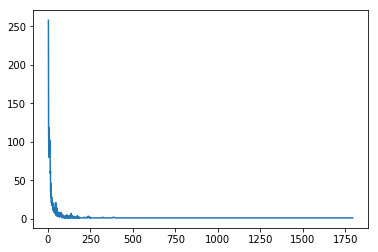

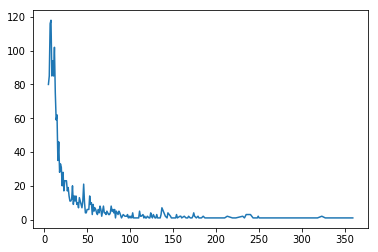

In [11]:
cutoff=2
xy_axis_if = list(Counter(lens_if).items())
xy_axis_labels = list(Counter(lens_labels).items())

xy_axis_if.sort(key=lambda x: x[0])
xy_axis_if=np.array(xy_axis_if)
xy_axis_if=xy_axis_if[np.where(xy_axis_if[:,0]>cutoff)]
x_axis_if, y_axis_if = zip(*xy_axis_if)
plt.plot(x_axis_if, y_axis_if)
plt.show()

xy_axis_labels.sort(key=lambda x: x[0])
xy_axis_labels=np.array(xy_axis_labels)
xy_axis_labels=xy_axis_if[np.where(xy_axis_labels[:,0]>cutoff)]
x_axis_labels, y_axis_labels = zip(*xy_axis_labels)
plt.plot(x_axis_labels, y_axis_labels)
plt.show()

In [12]:
lens = lens_labels
X_10 = np.where((lens<=10) )[0]
X_100 =  np.where(((lens>10) & (lens<=100)))[0]
X_1000 =  np.where((lens>100) & (lens<=1000))[0]
X_10000 = np.where((lens>1000) & (lens<=10000))[0]

In [13]:
print(len(X_10))
print(len(X_100))
print(len(X_1000))
print(len(X_10000))
sum([len(X_10),len(X_100),len(X_1000),len(X_10000)])

3207
6489
176
6


9878

In [14]:
indices=list(zip(range(len(lens_labels)),lens_labels))
indices=sorted(indices, key=lambda x:x[1])
indices, lens_sorted = zip(*indices)
indices = np.array(indices)[np.where(np.array(lens_sorted)>cutoff)]
lens_sorted = np.array(lens_sorted)

In [15]:
print(len(indices))
indices=indices[39:]
print(lens_labels[2])
Y_labels = np.array(Y_labels)

9539
3


In [16]:
X_labels=np.array(X_labels)

In [17]:
def length(sequence):
    used = tf.sign(tf.reduce_max(tf.abs(sequence), 2))
    length = tf.reduce_sum(used, 1)
    length = tf.cast(length, tf.int32)
    return length

def cost(output, target):
    # Compute cross entropy for each frame.
    cross_entropy = target * tf.log(output)
    cross_entropy = -tf.reduce_sum(cross_entropy, 2)
    mask = tf.sign(tf.reduce_max(tf.abs(target), 2))
    cross_entropy *= mask
    # Average over actual sequence lengths.
    cross_entropy = tf.reduce_sum(cross_entropy, 1)
    cross_entropy /= tf.reduce_sum(mask, 1)
    return tf.reduce_mean(cross_entropy)

def last_relevant(output, length):
    batch_size = tf.shape(output)[0]
    max_length = tf.shape(output)[1]
    out_size = int(output.get_shape()[2])
    index = tf.range(0, batch_size) * max_length + (length - 1)
    flat = tf.reshape(output, [-1, out_size])
    relevant = tf.gather(flat, index)
    return relevant


In [33]:
N = indices.shape[0]
output_size = np.max(Y_labels[:,1])+1
learning_rate = 1e-1
batch_size = 50
hidden_size = 100
num_features =embeddings.shape[1]
num_epochs = 100
n_steps = N//batch_size

In [19]:
rnn_graph = tf.Graph()

with rnn_graph.as_default():
    sequence = tf.placeholder(tf.float32,[batch_size, None ,num_features])
    labels= tf.placeholder(tf.float32,[batch_size,output_size])
    seq_len = tf.placeholder(tf.int32, [batch_size])

    cell=tf.contrib.rnn.BasicRNNCell(hidden_size)
    W = tf.Variable(tf.random_normal([hidden_size, output_size]))
    b = tf.Variable(tf.random_normal([output_size]))

    initial_state = cell.zero_state(batch_size, dtype=tf.float32)


    outputs, state = tf.nn.dynamic_rnn(cell, sequence, 
            initial_state=initial_state, sequence_length=seq_len)

    batch_len_t = tf.shape(outputs)[0]
    max_length_t = tf.shape(outputs)[1]
    out_size_t = int(outputs.get_shape()[2])
    index_t = tf.range(0, batch_len_t) * max_length_t + (seq_len - 1)
    flat_t = tf.reshape(outputs, [-1, out_size_t])
    output = tf.gather(flat_t, index_t)


    logits = tf.matmul(output,W)+b
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=logits)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [35]:
with tf.Session(graph=rnn_graph) as session:
    iop = tf.global_variables_initializer()
    session.run(iop)
    for epoch in range(num_epochs):
        acc_sum=0
        for step in range(n_steps):
            index = indices[batch_size*(step):batch_size*(step+1)]
            sequence_len = lens_labels[index]
            max_len = np.max(sequence_len)
            data = np.zeros([batch_size,max_len,num_features])
            batch_labels = np.eye(output_size)[Y_labels[index,1]]
            X = X_labels[index]
            for i in range(batch_size):
                for j in range(len([X[i]])):
                    data[i,j,:] = embeddings[X[i][j]]
            feed = {sequence:data,labels:batch_labels,seq_len:sequence_len}
            
            acc, pred, _ = session.run([accuracy, correct_prediction, train_step], feed_dict=feed)
            acc_sum += acc
            
        print("acc:",acc_sum/n_steps)
    

acc: 0.405052633093
acc: 0.383789472243
acc: 0.392842104639
acc: 0.396526316906
acc: 0.384210527473
acc: 0.398842107093
acc: 0.400947368851
acc: 0.4165263164
acc: 0.390105263301
acc: 0.456315789568
acc: 0.347052632292
acc: 0.339789474285
acc: 0.330421052403
acc: 0.362000000653
acc: 0.358526315462
acc: 0.376947368211
acc: 0.356105263668
acc: 0.355263156679
acc: 0.339684210875
acc: 0.33684210491
acc: 0.360631578847
acc: 0.353052631785
acc: 0.339894736146
acc: 0.369789473634
acc: 0.356526316036
acc: 0.361263157545
acc: 0.357894737705
acc: 0.359473684175
acc: 0.359368421294
acc: 0.37052631535
acc: 0.381263158117
acc: 0.383789473262
acc: 0.372315789975
acc: 0.366526316361
acc: 0.361368422112
acc: 0.340000000008
acc: 0.349578948142
acc: 0.361894736694
acc: 0.364736842286
acc: 0.357684210688
acc: 0.387578948195
acc: 0.373789474643
acc: 0.364631579091
acc: 0.360736842689
acc: 0.360842106785
acc: 0.369368423267
acc: 0.372947368163
acc: 0.353473684545
acc: 0.370631578937
acc: 0.363368422185
acc: